# Imports

In [1]:
try:
    import yfinance as yf
    import numpy as np
    import pandas as pd
    import statsmodels.api as sm
    from scipy.optimize import minimize
    import matplotlib.pyplot as plt
except ImportError:
    %pip -q install yfinance statsmodels scipy matplotlib pandas numpy
    import yfinance as yf
    import numpy as np
    import pandas as pd
    import statsmodels.api as sm
    from scipy.optimize import minimize
    import matplotlib.pyplot as plt

pd.set_option("display.float_format", lambda x: f"{x:,.6f}")

Note: you may need to restart the kernel to use updated packages.


In [7]:
TICKERS = ["AAPL", "MSFT", "GOOGL", "TSLA"]
BENCHMARK = "^GSPC" #S&P 500                           
START = "2023-01-01"                        
END = None                                    
INTERVAL = "1d"                              
TRADING_DAYS = 252     

RISK_FREE_ANNUAL = 0.04

SHORT_ALLOWED = False

In [8]:
def fetch_prices(tickers, start, end, interval):
    raw = yf.download(
        tickers, start=start, end=end, interval=interval,
        auto_adjust=True, progress=False
    )
    # yfinance returns a MultiIndex with first level = field ("Close") for multi-ticker requests
    if isinstance(raw.columns, pd.MultiIndex):
        if "Close" not in raw.columns.levels[0]:
            raise KeyError(f"'Close' not found. Available top-level fields: {list(raw.columns.levels[0])}")
        prices = raw["Close"].copy()          # columns = tickers
    else:
        # Single-ticker case -> DataFrame with 'Close' column
        if "Close" in raw.columns:
            prices = raw["Close"].to_frame()
        else:
            # Last-ditch: if a plain Series came back
            prices = raw.to_frame()
    return prices.dropna(how="all")

prices_all = fetch_prices(TICKERS + [BENCHMARK], START, END, INTERVAL)

if BENCHMARK in prices_all.columns:
    prices_stocks = prices_all[TICKERS]
    prices_bench  = prices_all[BENCHMARK]
else:
    prices_stocks = prices_all[TICKERS]
    prices_bench  = fetch_prices([BENCHMARK], START, END, INTERVAL).iloc[:, 0] #in case benchmark didn't arrive in the batch

display(prices_all.tail())


Ticker,AAPL,GOOGL,MSFT,TSLA,^GSPC
Date,,,,,
2025-09-19,245.500000,254.720001,517.929993,426.070007,"6,664.359863"
2025-09-22,256.079987,252.529999,514.450012,434.209991,"6,693.750000"
2025-09-23,254.429993,251.660004,509.230011,425.850006,"6,656.919922"
2025-09-24,252.309998,247.139999,510.149994,442.790009,"6,637.970215"
2025-09-25,256.869995,245.789993,507.029999,423.390015,"6,604.720215"


In [17]:
# Compute log returns
return_stocks = np.log(prices_stocks / prices_stocks.shift(1)).dropna()

return_bench = np.log(prices_bench / prices_bench.shift(1)).dropna()
return_bench = return_bench.reindex(return_stocks.index).dropna()

# Annualization helpers
rf_daily = RISK_FREE_ANNUAL / TRADING_DAYS
mu_hist_annual = return_stocks.mean() * TRADING_DAYS                 # historical mean (annualised)
cov_annual = return_stocks.cov() * TRADING_DAYS                      # annualised covariance
mu_bench_annual = return_bench.mean() * TRADING_DAYS

print("Data shape — returns:", return_stocks.shape)
print("Annualized (hist) mean returns:")
display(mu_hist_annual.to_frame("mu_hist_annual"))

print("Cov_annual:")
display(cov_annual.style.set_caption("Annualized Covariance Matrix"))

Data shape — returns: (684, 4)
Annualized (hist) mean returns:


,mu_hist_annual
Ticker,
AAPL,0.270311
MSFT,0.284215
GOOGL,0.376293
TSLA,0.502982


Cov_annual:


Ticker,AAPL,MSFT,GOOGL,TSLA
Ticker,,,,
AAPL,0.068293,0.030838,0.036889,0.071377
MSFT,0.030838,0.055248,0.037457,0.052250
GOOGL,0.036889,0.037457,0.092073,0.069072
TSLA,0.071377,0.052250,0.069072,0.368099


In [12]:
# CAPM regressions: (R_i - R_f) = alpha + beta * (R_m - R_f) + epsilon
# Using OLS via statsmodels

excess_m = return_bench - rf_daily
capm_rows = []
for tkr in TICKERS:
    y = (return_stocks[tkr] - rf_daily).dropna()
    x = sm.add_constant(excess_m.loc[y.index])
    model = sm.OLS(y, x).fit()
    alpha = model.params.get("const", np.nan)
    beta = model.params.get(excess_m.name, np.nan)
    t_alpha = model.tvalues.get("const", np.nan)
    t_beta = model.tvalues.get(excess_m.name, np.nan)
    r2 = model.rsquared
    capm_rows.append([tkr, alpha, beta, t_alpha, t_beta, r2])

capm_df = pd.DataFrame(capm_rows, columns=["Ticker","Alpha (daily)","Beta","t(alpha)","t(beta)","R^2"])
capm_df["Alpha (annual)"] = capm_df["Alpha (daily)"] * TRADING_DAYS
capm_df = capm_df.set_index("Ticker")
display(capm_df)

# Expected return via CAPM
rf_annual = RISK_FREE_ANNUAL
exp_return_capm_annual = rf_annual + capm_df["Beta"] * (mu_bench_annual - rf_annual)
exp_return_capm_annual.name = "mu_capm_annual"
display(exp_return_capm_annual.to_frame())

,Alpha (daily),Beta,t(alpha),t(beta),R^2,Alpha (annual)
Ticker,,,,,,
AAPL,0.000154,1.187846,0.337714,25.171612,0.481609,0.038683
MSFT,0.000293,1.056533,0.708828,24.641099,0.470983,0.073771
GOOGL,0.000579,1.179811,0.981900,19.264727,0.352406,0.145961
TSLA,0.000367,2.296923,0.306683,18.498213,0.334104,0.092433


,mu_capm_annual
Ticker,
AAPL,0.231628
MSFT,0.210444
GOOGL,0.230332
TSLA,0.410549


In [16]:
# Choose which expected returns to use in optimization:
# - CAPM-based (exp_ret_capm_annual)
# - Historical mean (mu_hist_annual)

USE_CAPM = True
mu = exp_return_capm_annual if USE_CAPM else mu_hist_annual
print("Using CAPM expected returns?" , USE_CAPM)
display(mu.to_frame("mu_in_use"))

Using CAPM expected returns? True


,mu_in_use
Ticker,
AAPL,0.231628
MSFT,0.210444
GOOGL,0.230332
TSLA,0.410549


In [18]:
# Optimization helpers (long-only by default)

def portfolio_performance(weights, mu, cov, rf):
    ret = np.dot(weights, mu.values)
    vol = np.sqrt(np.dot(weights, np.dot(cov.values, weights)))
    sharpe = (ret - rf) / vol if vol > 0 else np.nan
    return ret, vol, sharpe

def max_sharpe_portfolio(mu, cov, rf, short_allowed=False):
    n = len(mu)
    x0 = np.ones(n) / n
    bounds = None if short_allowed else [(0.0, 1.0)] * n
    cons = ({"type":"eq","fun": lambda w: np.sum(w) - 1.0},)

    def neg_sharpe(w):
        r, v, s = portfolio_performance(w, mu, cov, rf)
        return -s

    res = minimize(neg_sharpe, x0=x0, method="SLSQP", bounds=bounds, constraints=cons, options={"maxiter":10_000})
    return res

def min_variance_portfolio(mu, cov, short_allowed=False):
    n = len(mu)
    x0 = np.ones(n) / n
    bounds = None if short_allowed else [(0.0, 1.0)] * n
    cons = ({"type":"eq","fun": lambda w: np.sum(w) - 1.0},)

    def port_var(w):
        return np.dot(w, np.dot(cov.values, w))

    res = minimize(port_var, x0=x0, method="SLSQP", bounds=bounds, constraints=cons, options={"maxiter":10_000})
    return res

def efficient_frontier(mu, cov, rf, points=50, short_allowed=False):
    n = len(mu)
    bnds = None if short_allowed else [(0.0, 1.0)] * n
    cons_base = [{"type":"eq","fun": lambda w: np.sum(w) - 1.0}]

    mus = np.linspace(mu.min(), mu.max(), points)
    rets, vols, ws = [], [], []
    for target in mus:
        cons = cons_base + [{"type":"eq","fun": lambda w, t=target: np.dot(w, mu.values) - t}]
        x0 = np.ones(n)/n
        res = minimize(lambda w: np.dot(w, np.dot(cov.values, w)),
                       x0=x0, method="SLSQP", bounds=bnds, constraints=cons, options={"maxiter":10_000})
        if res.success:
            w = res.x
            r, v, _ = portfolio_performance(w, mu, cov, rf)
            rets.append(r); vols.append(v); ws.append(w)
    return np.array(rets), np.array(vols), np.array(ws)

In [19]:
# Run optimizations
rf = rf_annual
res_ms = max_sharpe_portfolio(mu, cov_annual, rf, short_allowed=SHORT_ALLOWED)
res_mv = min_variance_portfolio(mu, cov_annual, short_allowed=SHORT_ALLOWED)

if not res_ms.success:
    print("Max-Sharpe optimization failed:", res_ms.message)
if not res_mv.success:
    print("Min-Var optimization failed:", res_mv.message)

w_ms = res_ms.x
w_mv = res_mv.x
w_eq = np.ones(len(mu)) / len(mu)

perf_ms = portfolio_performance(w_ms, mu, cov_annual, rf)
perf_mv = portfolio_performance(w_mv, mu, cov_annual, rf)
perf_eq = portfolio_performance(w_eq, mu, cov_annual, rf)

weights_df = pd.DataFrame({
    "Max-Sharpe": w_ms,
    "Min-Variance": w_mv,
    "Equal-Weight": w_eq
}, index=mu.index)

perf_df = pd.DataFrame(
    [perf_ms, perf_mv, perf_eq],
    index=["Max-Sharpe","Min-Variance","Equal-Weight"],
    columns=["Return (ann.)","Volatility (ann.)","Sharpe"]
)

display(weights_df)
display(perf_df)

,Max-Sharpe,Min-Variance,Equal-Weight
Ticker,,,
AAPL,0.349770,0.343457,0.250000
MSFT,0.393678,0.523933,0.250000
GOOGL,0.150304,0.132610,0.250000
TSLA,0.106247,0.000000,0.250000


,Return (ann.),Volatility (ann.),Sharpe
Max-Sharpe,0.242103,0.227682,0.887658
Min-Variance,0.220357,0.210962,0.854928
Equal-Weight,0.270738,0.271510,0.849834


# Takeaways

### Equal weight, the most naive method performed surprisingly well in terms of raw returns.
### Min-variance minimises the risk (volatility), but sacrifices on return.
### Max-Sharpe offers the greatest return adjusted for per unit risk. 

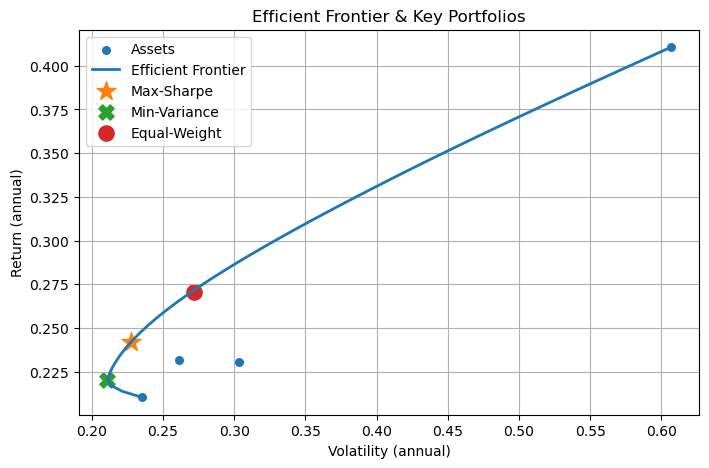

In [20]:
# Efficient Frontier plot
rets, vols, ws = efficient_frontier(mu, cov_annual, rf, points=60, short_allowed=SHORT_ALLOWED)

plt.figure(figsize=(8,5))
plt.scatter(np.sqrt(np.diag(cov_annual)), mu, s=30, label="Assets")  # individual assets (risk, return)
plt.plot(vols, rets, lw=2, label="Efficient Frontier")
plt.scatter(perf_ms[1], perf_ms[0], marker="*", s=200, label="Max-Sharpe")
plt.scatter(perf_mv[1], perf_mv[0], marker="X", s=120, label="Min-Variance")
plt.scatter(perf_eq[1], perf_eq[0], marker="o", s=120, label="Equal-Weight")
plt.xlabel("Volatility (annual)")
plt.ylabel("Return (annual)")
plt.title("Efficient Frontier & Key Portfolios")
plt.legend()
plt.grid(True)
plt.show()

# Comparison of growth overtime of the key portfolios

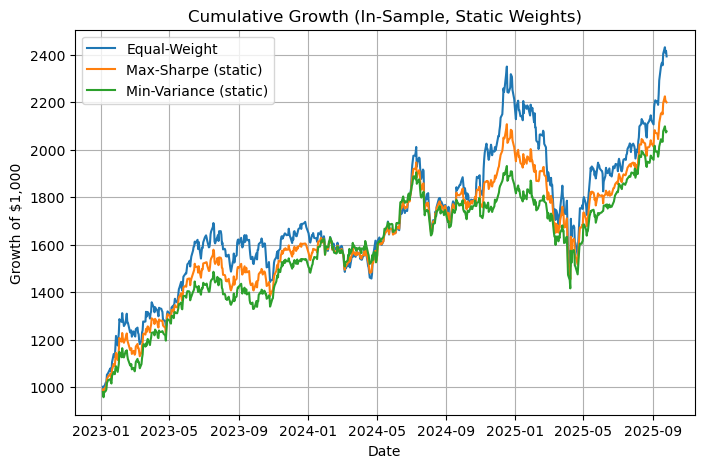

In [28]:
def backtest(weights, returns):
    # returns: DataFrame of periodic returns (simple)
    port_return = (returns * weights).sum(axis=1)
    cum = (1 + port_return).cumprod() * 1000
    return cum

cum_eq = backtest(w_eq, return_stocks)
cum_mv = backtest(w_mv, return_stocks)
cum_ms = backtest(w_ms, return_stocks)

plt.figure(figsize=(8,5))
plt.plot(cum_eq.index, cum_eq.values, label="Equal-Weight")
plt.plot(cum_ms.index, cum_ms.values, label="Max-Sharpe (static)")
plt.plot(cum_mv.index, cum_mv.values, label="Min-Variance (static)")
plt.xlabel("Date"); plt.ylabel("Growth of $1,000")
plt.title("Cumulative Growth (In-Sample, Static Weights)")
plt.legend(); plt.grid(True); plt.show()